In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sample_t = np.linspace(-0.1, np.pi, 300)

short_amps = np.sin(sample_t)
long_amps = np.sin(sample_t-0.5)

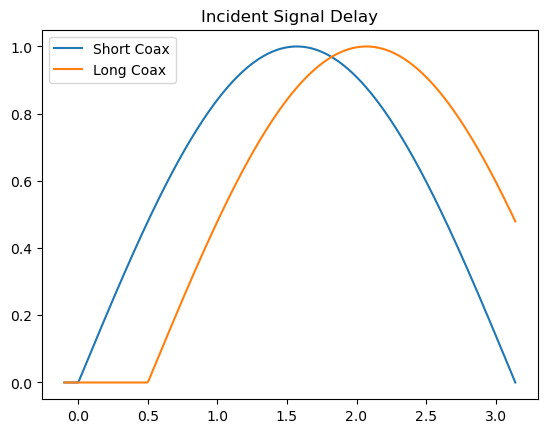

In [4]:
plt.plot(sample_t, [max(short_amps[i], 0) for i in range(len(short_amps))], label="Short Coax")
plt.plot(sample_t, [max(long_amps[i], 0) for i in range(len(long_amps))], label="Long Coax")
plt.title("Incident Signal Delay")
plt.legend()
plt.show()

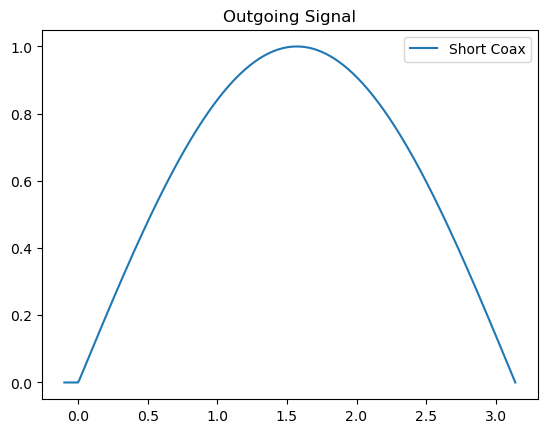

In [5]:
plt.plot(sample_t, [max(short_amps[i], 0) for i in range(len(short_amps))], label="Short Coax")
plt.title("Outgoing Signal")
plt.legend()
plt.show()

# Outline for Code

In [6]:
import pandas as pd
import scipy as sp
import csv

In [7]:
metadata = dict()
row_start = 14
filename_200k_1 = "sine/T0022ALL.CSV"
with open(filename_200k_1, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '1e-05',
 'Sample Interval': '1e-09',
 'Filter Frequency': '2e+08',
 'Record Length': '100000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '0.2',
 'Label': ''}

In [8]:
data_200k_1 = pd.read_csv(filename_200k_1, delimiter=",", header=row_start)

In [9]:
t_200k_1 = data_200k_1["TIME"].to_numpy()  # first trial for 200kHz
ch1_200k_1 = data_200k_1["CH1"].to_numpy()
ch2_200k_1 = data_200k_1["CH2"].to_numpy()
print(t_200k_1)

[-4.9560e-05 -4.9559e-05 -4.9558e-05 ...  5.0437e-05  5.0438e-05
  5.0439e-05]


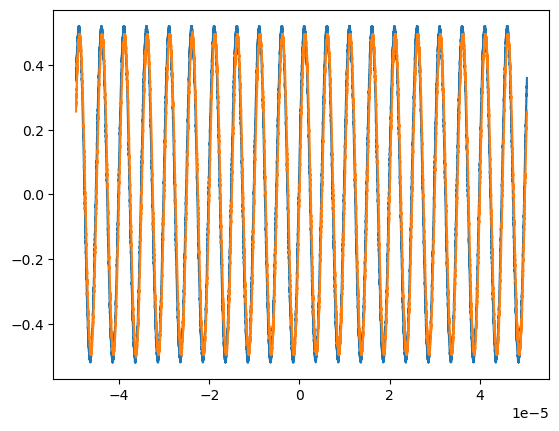

In [10]:
plt.plot(t_200k_1, ch1_200k_1)
plt.plot(t_200k_1, ch2_200k_1)
plt.show()

In [11]:
def sin_wave(t, omega, phi, a, c):
    return a * (np.sin(t * omega + phi)) + c

## TODO: CONVERT THIS WHOLE SECTION INTO A SINGLE FUNCTION TO GET THE PHASE SHIFT AND SPEED OF LIGHT FOR ANY GIVEN PAIR OF SINE WAVE FUNCTIONS

In [12]:
ff = np.fft.fftfreq(len(t_200k_1), (t_200k_1[1]-t_200k_1[0]))
Fyy = abs(np.fft.fft(ch1_200k_1))
guess_freq = abs(ff[np.argmax(Fyy[1:])+1])  # use a fast fourier transform to make frequency bins and then get the fft of the dataset to make a good guess of the frequency
# specifically it is finding the fast fourier transform, and then using the index of the first maximum of said fft, the index of that value in the frequency bins gives the right value - im not 100% certain i understand how the fft has the same bin size as the fftfreq

In [13]:
guess = [2 * np.pi * guess_freq, 0, np.std(ch1_200k_1) * 2.**0.5, np.mean(ch1_200k_1)]

In [14]:
poptch1200k1, pcovch1200k1 = sp.optimize.curve_fit(sin_wave, t_200k_1, ch1_200k_1, p0=guess)
poptch2200k1, pcovch2200k1 = sp.optimize.curve_fit(sin_wave, t_200k_1, ch2_200k_1, p0=guess)

To convert from phi (offset) which is in radians, to the time difference, need to have the phase difference between the two waves (next box), and in its base state if the short channel has a larger value of phi, that is good and you can simply use as is, but if the long channel has the larger value of phi, i think you need to add 2pi to the value. Then, divide that phi difference by the omega frequency, and divide the distance between the two values 

In [15]:
phi_200k_1 = (poptch1200k1 - poptch2200k1)[1]  # phase offset between the two channels

In [16]:
time_delay = phi_200k_1 / poptch1200k1[0]

In [17]:
(28.912 - 2.04) / time_delay

157042466.46361515

In [18]:
poptch1200k1, poptch2200k1

(array([ 1.25663342e+06,  2.14829720e-01,  5.12719516e-01, -4.74247883e-04]),
 array([ 1.25663834e+06, -1.96533352e-04,  4.91324550e-01, -1.82578257e-03]))

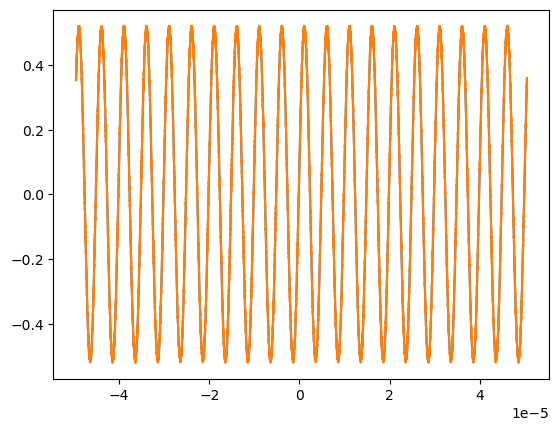

In [19]:
plt.plot(t_200k_1, sin_wave(t_200k_1, *poptch1200k1))
plt.plot(t_200k_1, ch1_200k_1)

In [21]:
length_diff = 28.912 - 2.04
length_err = np.sqrt(0.02 ** 2 + 0.144 ** 2)
length_rel_err = length_err / length_diff

In [31]:
def signal_prop_speed(time, short_channel, long_channel):
    freq_bins = np.fft.fftfreq(len(time), (time[1]-time[0]))
    fourier = abs(np.fft.fft(short_channel))
    freq_guess = abs(freq_bins[np.argmax(fourier[1:])+1])  # dont need to make a guess for each, sp takes it from here
    p0 = [2 * np.pi * freq_guess, 0, np.std(short_channel) * 2.**0.5, np.mean(short_channel)]
    short_popt, short_pcov = sp.optimize.curve_fit(sin_wave, time, short_channel, p0=p0)
    long_popt, long_pcov = sp.optimize.curve_fit(sin_wave, time, long_channel, p0=p0)
    short_uncerts = np.sqrt(np.diag(short_pcov))
    long_uncerts = np.sqrt(np.diag(long_pcov))
    phi_diff = abs(long_popt - short_popt)[1]
    time_diff = phi_diff / short_popt[0]
    signal_prop_speed = length_diff / time_diff
    freq_rel_err = short_uncerts[0] / short_popt[0]
    phi_rel_err = np.sqrt((short_uncerts[1] ** 2 + long_uncerts[1] ** 2)) / phi_diff
    signal_prop_err = signal_prop_speed * np.sqrt((length_rel_err) ** 2 + (freq_rel_err) ** 2 + (phi_rel_err) ** 2)
    return [signal_prop_speed, signal_prop_err, short_popt[0] / (2 * np.pi), short_uncerts[0] / (2 * np.pi)]  # speed, abs speed error, frequency, abs frequency err

In [32]:
signal_prop_speed(t_200k_1, ch1_200k_1, ch2_200k_1)  # works, need to run this code for all data, see if there is a dependance on frequency - make another function

[157042466.46361515, 850262.3876622637, 199999.42005677265, 0.1696025118940975]

In [33]:
c = 299792458  # m/s

In [84]:
def refractive_index(speed_arr):  # must use returned array from signal_prop_speed
    n = c / speed_arr[0]
    n_err = speed_arr[1] * n / speed_arr[0] # c has no error, so absolute error in index === abs err in v * n / v
    return np.array([n, n_err, speed_arr[2]])  # assuming that relative error in frequency is negligible

Goal:
 - Run signal_prop_speed for each of the datasets in the sine folder, or at least a list of them as desired.
   - Really I need to run for the averaged value for f=200kHz (22-26)
   - and a different function for the frequency dependence (22, 27-32)
 - Ideally these wouldn't require manually setting the datasets up for each one, but if necessary that is easily done. - 22 is set up
 - Function 1: run each of them, then take the average value of their refractive index and find the error of said average index
 - Function 2: run each of them, and then either output a plot of them or a thing that can be plotted - not trying to find exactly how it varies, just trying to see if it DOES vary at these frequencies
   - Maybe do a straight line running through the average value?

# Refractive Index at 200 kHz, Multiple Runs

In [85]:
refractive_index(signal_prop_speed(t_200k_1, ch1_200k_1, ch2_200k_1))

array([1.90898974e+00, 1.03356895e-02, 1.99999420e+05])

In [78]:
def avg_index(arr_arr):  # array of arrays of the columns in the dataset
    n_arr = np.zeros([len(arr_arr), 3])
    for i in range(len(arr_arr)):
        n_arr[i] = refractive_index(signal_prop_speed(*arr_arr[i]))
    n_arr = np.transpose(n_arr)
    n_avg = np.mean(n_arr[0])
    n_err = 0
    for i in range(len(n_arr[0])):
        n_err += n_arr[1][i] ** 2
    n_err = np.sqrt(n_err) / len(n_arr[0])
    return [n_avg, n_err]

In [79]:
array_200k_trials = np.zeros([5, 3, 100000])
for i in range(2,7):
    filename_200k = f"sine/T002{i}ALL.CSV"
    data_200k = pd.read_csv(filename_200k, delimiter=",", header=row_start)
    t_200k = data_200k_1["TIME"].to_numpy()  # first trial for 200kHz
    short_200k = data_200k_1["CH1"].to_numpy()
    long_200k = data_200k_1["CH2"].to_numpy()
    array_200k_trials[i-2] = np.array([t_200k, short_200k, long_200k])

In [81]:
refractive_index_200kHz = avg_index(array_200k_trials)

# Refractive Index over Range of Frequencies

## Is there a Visual Frequency Dependence? And is it anything other than Linear?